<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/nn-prediction-time-series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization

In [ ]:
#df = pd.read_csv('/kaggle/input/usd-rub-timeseries/UsdRubTime.csv', delimiter=';', decimal='.')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/machinelearning/refs/heads/main/test_datasets/UsdRubTime.csv',delimiter=';', decimal='.')


In [3]:
df.head()

,Close,Data,Position
0,0.988,22.08.1993,1
1,0.993,29.08.1993,8
2,1.000,05.09.1993,15
3,1.020,12.09.1993,22
4,1.300,19.09.1993,29


In [4]:
df_data = pd.to_datetime(df['Data'], dayfirst=True)
df_data.head()

,Data
0,1993-08-22
1,1993-08-29
2,1993-09-05
3,1993-09-12
4,1993-09-19


In [37]:
df_close = pd.DataFrame(df['Close'])
df_close.index = pd.to_datetime(df['Data'], dayfirst=True)
df_close.head()

,Close
Data,
1993-08-22,0.988
1993-08-29,0.993
1993-09-05,1.000
1993-09-12,1.020
1993-09-19,1.300


In [38]:
df.isnull().sum()

,0
Close,0
Data,0
Position,0


In [39]:
df_close.describe()

,Close
count,1542.000000
mean,35.306973
std,21.890677
min,0.988000
25%,25.754750
50%,29.871000
75%,57.287250
max,133.417000


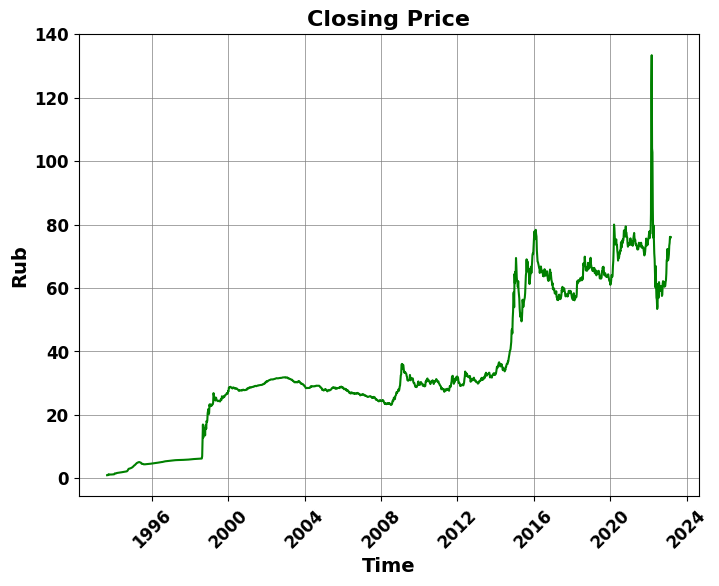

In [8]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(8, 6))
plt.plot(df_close, color='g')
plt.title('Closing Price', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Rub', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'grey', linewidth = 0.5)

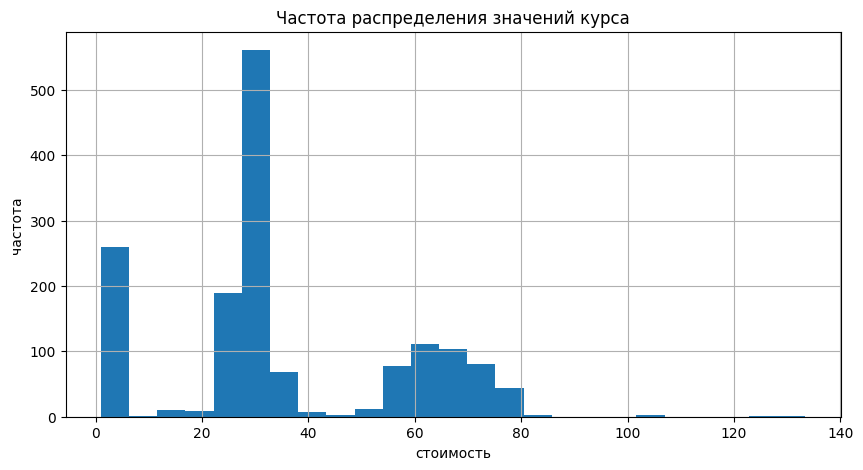

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['Close'], bins=25)
plt.title('Частота распределения значений курса')
plt.xlabel('стоимость')
plt.ylabel('частота')
plt.grid(True)
plt.show()

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# Prediction model (one step) - NN LSTM

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [45]:
df_close[["Close"]] = df_close[["Close"]].values.astype('float32')

train_size = int(len(df_close) * 0.6)
train_data, test_data = df_close[:train_size], df_close[train_size:]

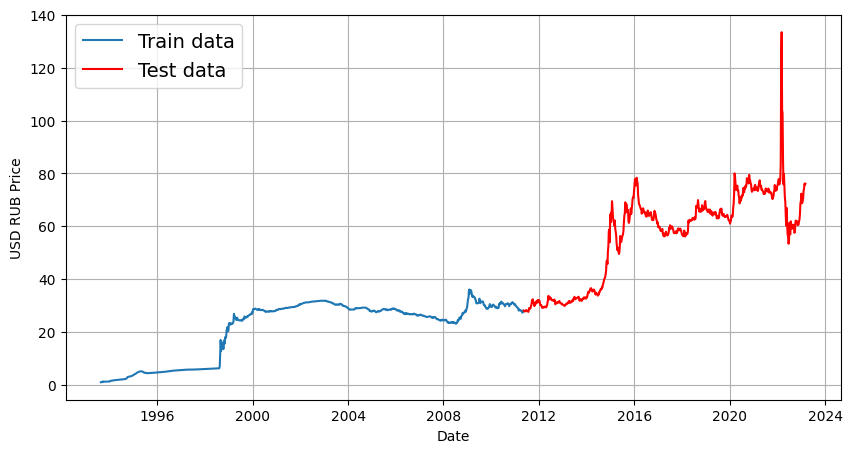

In [41]:
# Plot correctly made splits

plt.figure(figsize=(10, 5))
plt.plot(train_data['Close'], label="Train data")
plt.plot(test_data['Close'], 'r-', label="Test data")
plt.xlabel("Date")
plt.ylabel("USD RUB Price")
plt.legend(fontsize=14)
plt.grid()
plt.show();

In [16]:
df_close

,Close
Data,
1993-08-22,0.988
1993-08-29,0.993
1993-09-05,1.000
1993-09-12,1.020
1993-09-19,1.300
...,...
2023-02-05,73.348
2023-02-12,74.230
2023-02-19,76.135


In [42]:
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data[['Close']])
#scaled_test_data = scaler.transform(test_data[['Close']])
#scaled_test_data = scaler.fit_transform(test_data[['Close']])

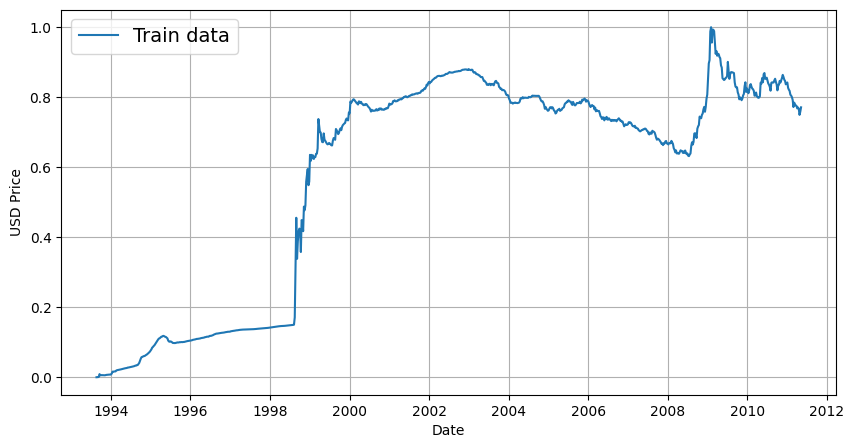

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(train_data['Close'].index, scaled_train_data, label="Train data")
#plt.plot(test_data['Close'].index, scaled_test_data, 'r-', label="Test data")
plt.xlabel("Date")
plt.ylabel("USD Price")
plt.legend(fontsize=14)
plt.grid()
plt.show();

**epochs**: Обучение разбито на *эпохи*. Эпоха это одна итерация по всем входным данным (это делается небольшими партиями).

**batch_size**: При передаче данных NumPy, модель разбивает данные на меньшие блоки (batches) и итерирует по этим блокам во время обучения. Это число указывает размер каждого блока данных. Помните, что последний блок может быть меньшего размера если общее число записей не делится на размер партии.

In [19]:
# LSTM model
def create_lstm_model(n_steps):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_steps, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [20]:
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
      # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [21]:
n_steps = 20
# split into samples
X, y = split_sequence(scaled_train_data, n_steps)

In [29]:
#model = Sequential()
#model.add(LSTM(7, input_shape=(1, 1)))
lstm_model = create_lstm_model(n_steps=n_steps)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
lstm_history = lstm_model.fit(X,y,epochs=10, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2786
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.5503e-04
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.1617e-04
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.0552e-04
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.7079e-04
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.2364e-04


In [24]:
scaler.inverse_transform(scaled_train_data[-n_steps:])

array([[30.433],
       [30.535],
       [30.003],
       [29.814],
       [29.693],
       [29.306],
       [29.222],
       [29.067],
       [28.792],
       [28.076],
       [28.517],
       [28.345],
       [28.23 ],
       [28.2  ],
       [27.936],
       [28.031],
       [27.91 ],
       [27.285],
       [27.604],
       [28.043]])

In [26]:
x_input = scaled_train_data[-n_steps:]
x_input = x_input.reshape((1, n_steps, n_features))
yhat = lstm_model.predict(x_input, verbose=1)
print(scaler.inverse_transform(yhat))

[[28.142042]]


<ipython-input-27-8536b9a855e3>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(test_data['Close'].index[0],test_data['Close'][0],'gx', label = 'True Future')


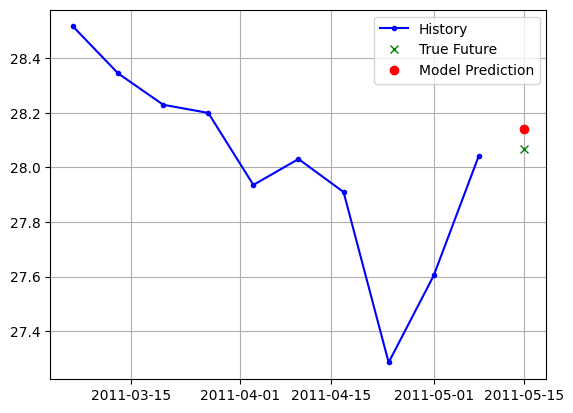

In [27]:
plt.plot(train_data['Close'].index[-10:],train_data[-10:],'-b.', label = 'History')
plt.plot(test_data['Close'].index[0],test_data['Close'][0],'gx', label = 'True Future')
plt.plot(test_data['Close'].index[0],scaler.inverse_transform(yhat),'ro', label = 'Model Prediction')
plt.legend(loc='best')
plt.grid()


# Prediction model - LSTM self time series

In [30]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [35]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [31]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

In [73]:
d = {'col1': train_data['Close'].index[:], 'col2': train_data['Close'].values}
df = pd.DataFrame(data=d)

In [87]:
lookback = 1
X_train, y_train = create_dataset(train_data.values, lookback=lookback)
X_test, y_test = create_dataset(test_data.values, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([924, 1, 1]) torch.Size([924, 1, 1])
torch.Size([616, 1, 1]) torch.Size([616, 1, 1])


In [93]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


Epoch 0: train RMSE 20.1993, test RMSE 54.0602
Epoch 100: train RMSE 0.4598, test RMSE 23.7199


DatetimeIndex(['1993-08-22', '1993-08-29', '1993-09-05', '1993-09-12',
               '1993-09-19', '1993-09-26', '1993-10-03', '1993-10-10',
               '1993-10-17', '1993-10-24',
               ...
               '2023-01-01', '2023-01-08', '2023-01-15', '2023-01-22',
               '2023-01-29', '2023-02-05', '2023-02-12', '2023-02-19',
               '2023-02-26', '2023-03-05'],
              dtype='datetime64[ns]', name='Data', length=1542, freq=None)

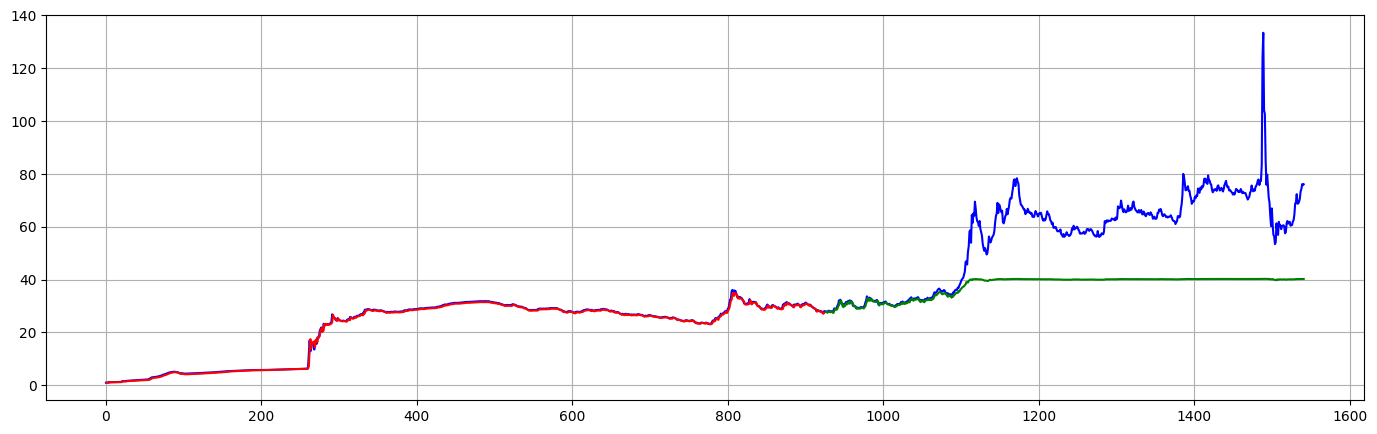

In [103]:
plt.rcParams['figure.figsize'] = (17,5)
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(df_close.values) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(df_close.values) * np.nan
    test_plot[train_size+lookback:len(df_close.values)] = model(X_test)[:, -1, :]
# plot
plt.plot(df_close.values, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.grid()
plt.show()

# Prediction model - NN LSTM loopback

In [ ]:
scaler = MinMaxScaler()
df_close_scaled = scaler.fit_transform(df_close['Close'].values.reshape(-1, 1))
train_size = int(len(df_close_scaled) * 0.6)
train_data, test_data = df_close_scaled[:train_size], df_close_scaled[train_size:]

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
x_train, y_train = create_dataset(train_data, look_back=15)
x_test, y_test = create_dataset(test_data, look_back=15)
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [ ]:
look_back = 15
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=7, batch_size=1, verbose=2)

Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


909/909 - 3s - 3ms/step - loss: 3.5750e-04
Epoch 2/7
909/909 - 1s - 1ms/step - loss: 7.2821e-05
Epoch 3/7
909/909 - 1s - 1ms/step - loss: 5.8560e-05
Epoch 4/7
909/909 - 2s - 2ms/step - loss: 4.7555e-05
Epoch 5/7
909/909 - 2s - 2ms/step - loss: 3.7151e-05
Epoch 6/7
909/909 - 1s - 1ms/step - loss: 3.4829e-05
Epoch 7/7
909/909 - 2s - 3ms/step - loss: 3.8070e-05


In [ ]:
lstm_predictions = model.predict(np.expand_dims(x_test, axis=-1))
lstm_predictions = scaler.inverse_transform(lstm_predictions)

testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(x_test[:,:,0]), lstm_predictions[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test Score: 10.43 RMSE


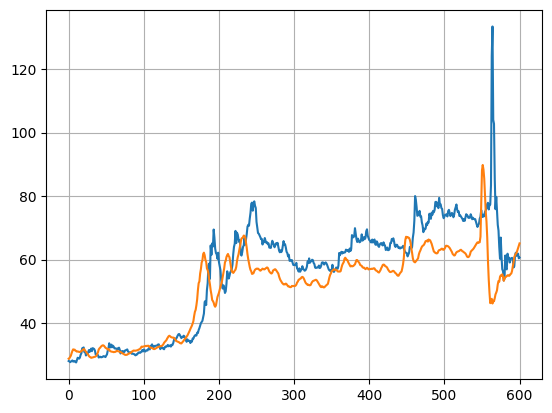

In [ ]:
plt.plot(scaler.inverse_transform(x_test[:,:,0]))
plt.plot(lstm_predictions)
plt.grid()
plt.show()

# Prediction model - ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
train_size = int(len(df_close) * 0.6)
train_data, test_data = df_close[:train_size], df_close[train_size:]

In [ ]:
arima_model = ARIMA(train_data['Close'].values, order=(3, 1, 3))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  925
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -510.521
Date:                Thu, 19 Sep 2024   AIC                           1035.041
Time:                        17:17:29   BIC                           1068.842
Sample:                             0   HQIC                          1047.937
                                - 925                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1329      0.042      3.130      0.002       0.050       0.216
ar.L2          0.1312      0.067      1.963      0.050       0.000       0.262
ar.L3         -0.1432      0.050     -2.869      0.0

In [ ]:
# ARIMA
arima_predictions = arima_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


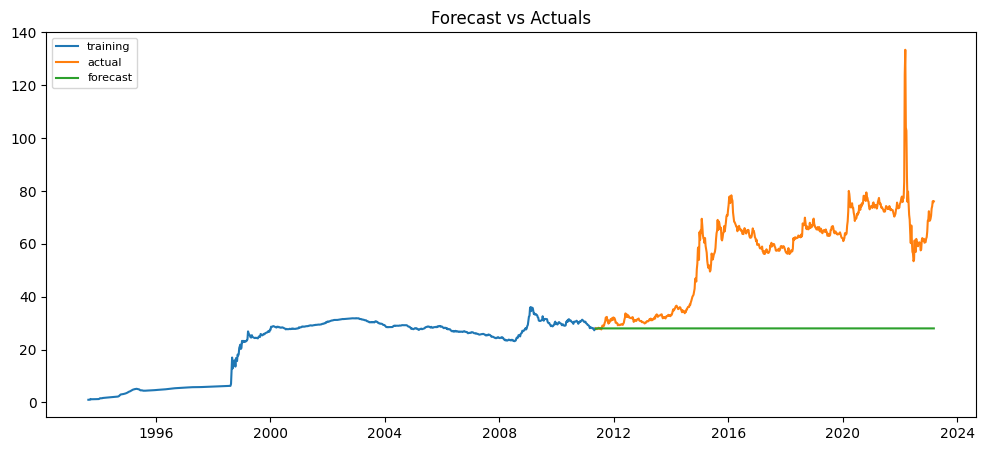

In [ ]:
# Forecast
fc = arima_model_fit.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')
plt.plot(fc_series, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()